In [2569]:
import numpy as np
import soundfile as sr
import matplotlib.pyplot as plt

In [2570]:
#2.1)

speech_data_tuple = sr.read("resources/female8khz.wav")
speech_data = speech_data_tuple[0]
sampling_rate = speech_data_tuple[1]

In [2571]:
import sounddevice as sd
sd.play(speech_data, sampling_rate)

In [2572]:
sampling_rate

8000

In [2573]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> [np.ndarray, np.ndarray]:
    millis_per_sample = 1000 / sampling_rate
    frame_length_num_points = frame_length / millis_per_sample
    frame_shift_num_points = frame_shift / millis_per_sample
    num_frames = int(np.floor((len(v_signal) - frame_length_num_points) / frame_shift_num_points) + 1)
    m_frames = np.zeros((num_frames, int(frame_length_num_points)))
    v_time_frame = np.zeros(num_frames)
    for i in range(num_frames):
        start = int(i * frame_shift_num_points)
        end = int(i * frame_shift_num_points + frame_length_num_points)
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + end)/(2*sampling_rate)
    return [m_frames, v_time_frame]

In [2574]:
frame_length = 32
frame_shift = 8

m_frames, v_time_frame = my_windowing(speech_data, sampling_rate, frame_length, frame_shift)

2.1.a) The signal is segmented because analyzing the whole signal at once might be too computationally expensive, particularly for longer audio segments. When doing convolutions both to analyze the signal in the frequency domain or apply analysis windows padding has to be done, this padding grows proportionally to the audio segment length. Therefore, it is more efficient to segment the audio signal in smaller segments.

2.1.b) Typically, 32ms length segment is considered appropriate for speech signal processing. This is because it has been found to be a good compromise between having a small segment length in terms of reducing computational complexity and having a segment long enough to capture the frequency characteristics of speech signals.

In [2575]:
#2.2)
def compute_power(x):
    return sum(abs(x)**2)/len(x)

In [2576]:
m_frames.shape

(278, 256)

In [2577]:
powers = np.zeros(m_frames.shape[0], dtype=np.float64)

for idx, item in enumerate(m_frames):
    powers[idx] = compute_power(item)

powers.shape

(278,)

In [2578]:
powers

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2579]:
v_time_frame*sampling_rate

array([  128.,   192.,   256.,   320.,   384.,   448.,   512.,   576.,
         640.,   704.,   768.,   832.,   896.,   960.,  1024.,  1088.,
        1152.,  1216.,  1280.,  1344.,  1408.,  1472.,  1536.,  1600.,
        1664.,  1728.,  1792.,  1856.,  1920.,  1984.,  2048.,  2112.,
        2176.,  2240.,  2304.,  2368.,  2432.,  2496.,  2560.,  2624.,
        2688.,  2752.,  2816.,  2880.,  2944.,  3008.,  3072.,  3136.,
        3200.,  3264.,  3328.,  3392.,  3456.,  3520.,  3584.,  3648.,
        3712.,  3776.,  3840.,  3904.,  3968.,  4032.,  4096.,  4160.,
        4224.,  4288.,  4352.,  4416.,  4480.,  4544.,  4608.,  4672.,
        4736.,  4800.,  4864.,  4928.,  4992.,  5056.,  5120.,  5184.,
        5248.,  5312.,  5376.,  5440.,  5504.,  5568.,  5632.,  5696.,
        5760.,  5824.,  5888.,  5952.,  6016.,  6080.,  6144.,  6208.,
        6272.,  6336.,  6400.,  6464.,  6528.,  6592.,  6656.,  6720.,
        6784.,  6848.,  6912.,  6976.,  7040.,  7104.,  7168.,  7232.,
      

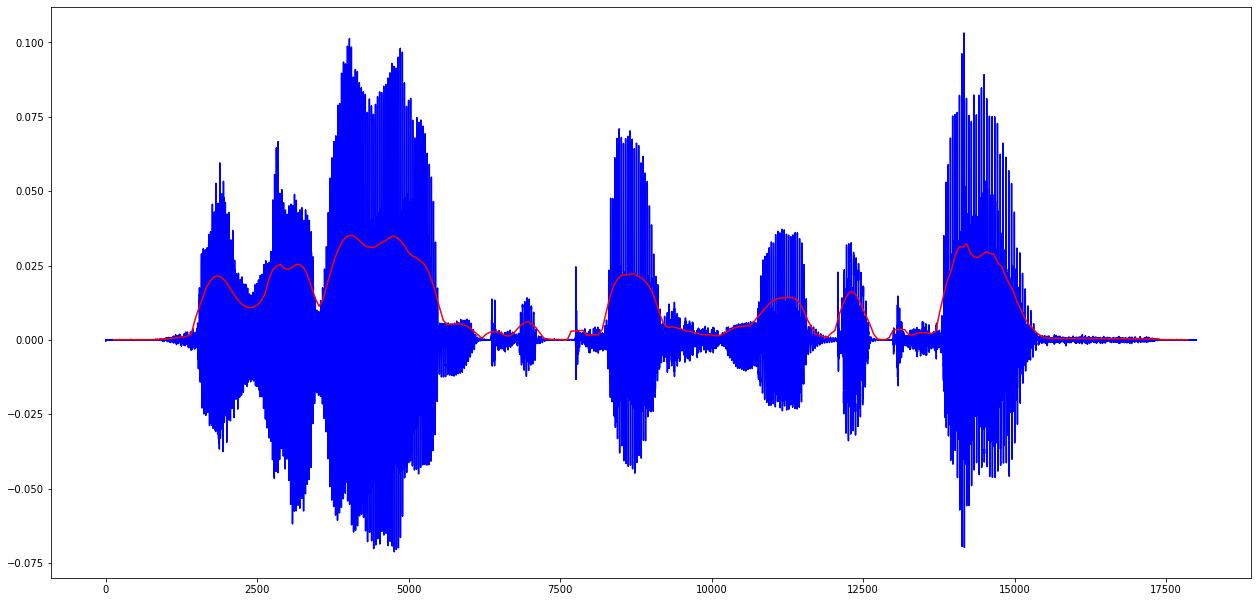

In [2580]:
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.plot(np.arange(stop=len(speech_data), dtype=np.int32),speech_data, c='b')
plt.plot(np.array(v_time_frame*sampling_rate, dtype=np.int32), np.sqrt(powers), c='r')
plt.show()

2.3.a)

2.3.b)

In [2581]:
def zero_crossings(x):
    return np.sum(x[:-1]*x[1:] < 0)

In [2582]:
def is_voiced(x, threshold):
    num_frame_samples = len(m_frames[0])
    crossings = zero_crossings(x)/num_frame_samples
    return 1 if crossings < threshold else 0

In [2583]:
threshold = 0.29
voiced_unvoiced = np.zeros(m_frames.shape[0])
for idx, item in enumerate(m_frames):
    voiced_unvoiced[idx] = is_voiced(item, threshold)

voiced_unvoiced

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

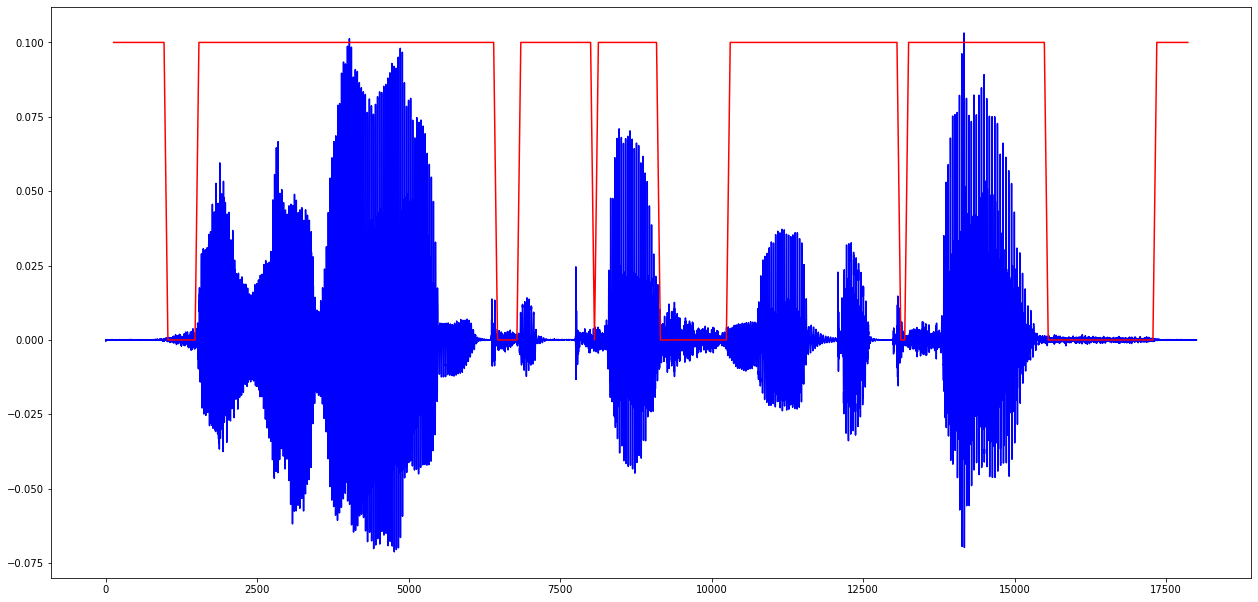

In [2584]:
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.plot(np.arange(stop=len(speech_data), dtype=np.int32),speech_data, c='b')
plt.plot(np.array(v_time_frame*sampling_rate, dtype=np.int32), voiced_unvoiced*0.1, c='r')
plt.show()

2.3.g) Silence

In [2585]:
#2.4)
def auto_correlation(frames):
    acf = np.convolve(frames[0], np.flip(frames[0]))
    acf_size = acf.shape[0]
    acfs = np.zeros((frames.shape[0], acf_size))
    for i in range(frames.shape[0]):
        acfs[i] = np.convolve(frames[i], np.flip(frames[i]))

    return acfs

In [2586]:
def remove_negatives(acfs):
    acfs_positive = np.zeros((acfs.shape[0], int(acfs.shape[1]/2)+1))
    for i in range(acfs.shape[0]):
        acfs_positive[i] = acfs[i][int(acfs.shape[1]/2):acfs.shape[1]]
    return acfs_positive

In [2587]:
def calc_fundamental_freqs(acfs_positive):
    search_range_min = int(sampling_rate/400)
    search_range_max = int(sampling_rate/80)

    fundamental_freqs = np.zeros(acfs_positive.shape[0])
    for i in range(acfs_positive.shape[0]):
        acf_range = acfs_positive[i][search_range_min: search_range_max+1]
        sample_idx = acf_range.argmax() + search_range_min
        millis = sample_idx / sampling_rate
        fundamental_freqs[i] = 1 / millis
    return fundamental_freqs

In [2588]:
def estimate_f0(m_frames):
    acfs = auto_correlation(m_frames)
    acfs_positive = remove_negatives(acfs)
    fundamental_freqs = calc_fundamental_freqs(acfs_positive)
    return np.array(fundamental_freqs, dtype=np.int32)

In [2589]:
fundamental_freqs = estimate_f0(m_frames)
fundamental_freqs

array([285, 275, 275, 333, 347, 347, 222, 222, 380, 363, 166, 400,  98,
       363, 333, 296, 100,  80,  86, 160, 106, 250, 258, 266, 266, 266,
       258, 258, 258, 258, 258, 258, 266, 266, 266, 266, 266, 266, 266,
       275, 275, 275, 275, 266, 266, 266, 266, 266, 266, 258, 258, 258,
       258, 258, 258, 258, 258, 258, 250, 250, 250, 242, 242, 242, 242,
       242, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       242, 242, 242, 242, 242, 363, 177, 177, 177, 363, 133, 363, 222,
       242, 228, 222, 216, 216, 216, 210, 200, 210, 222, 222, 222, 400,
       400, 380, 380, 380, 380, 333, 333, 333, 333, 222, 235, 228, 228,
       228, 222, 222, 222, 222, 222, 222, 222, 228, 228, 228, 228, 228,
       166, 121, 222,  91, 380, 380, 123, 380, 380, 190,  86, 307,  90,
       228, 258, 242, 242, 242, 242, 235, 235, 235, 228, 228, 228, 228,
       228, 228, 228, 222, 222, 222, 222, 222, 222, 216, 216, 21

In [2590]:
def compute_freq_axis(m_stft: np.ndarray):
    return np.linspace(0, sampling_rate//2, num=m_stft.shape[1])

def remove_upper_half_spectrum(m_stft: np.ndarray) -> np.ndarray:
    m_stft_new = m_stft[:, :(int(m_stft.shape[1]/2)+1)]
    return m_stft_new

In [2591]:
def compute_stft(v_signal: np.ndarray, fs: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray) -> [np.ndarray, np.ndarray, np.ndarray]:
    m_frames, v_time_frame = my_windowing(v_signal, fs, frame_length, frame_shift)
    m_stft_full = np.zeros(m_frames.shape, dtype=np.complex128)
    #v_analysis_window = v_analysis_window(m_frames.shape[1])
    for i in range(m_frames.shape[0]):
        m_stft_full[i] = np.fft.fft(m_frames[i]*v_analysis_window)
    #v_freq = np.fft.rfftfreq(m_stft_full.shape[1], 1/fs)
    m_stft = remove_upper_half_spectrum(m_stft_full)
    v_freq = compute_freq_axis(m_stft)
    return [m_stft, v_freq, v_time_frame]

In [2592]:
from scipy.signal import get_window

millis_per_sample = 1000 / sampling_rate
frame_length_samples = int(frame_length / millis_per_sample)
analysis_window = get_window('hann', int(frame_length_samples), fftbins=True)
m_stft, v_freq, v_time_frame = compute_stft(speech_data, sampling_rate, frame_length, frame_shift, analysis_window)

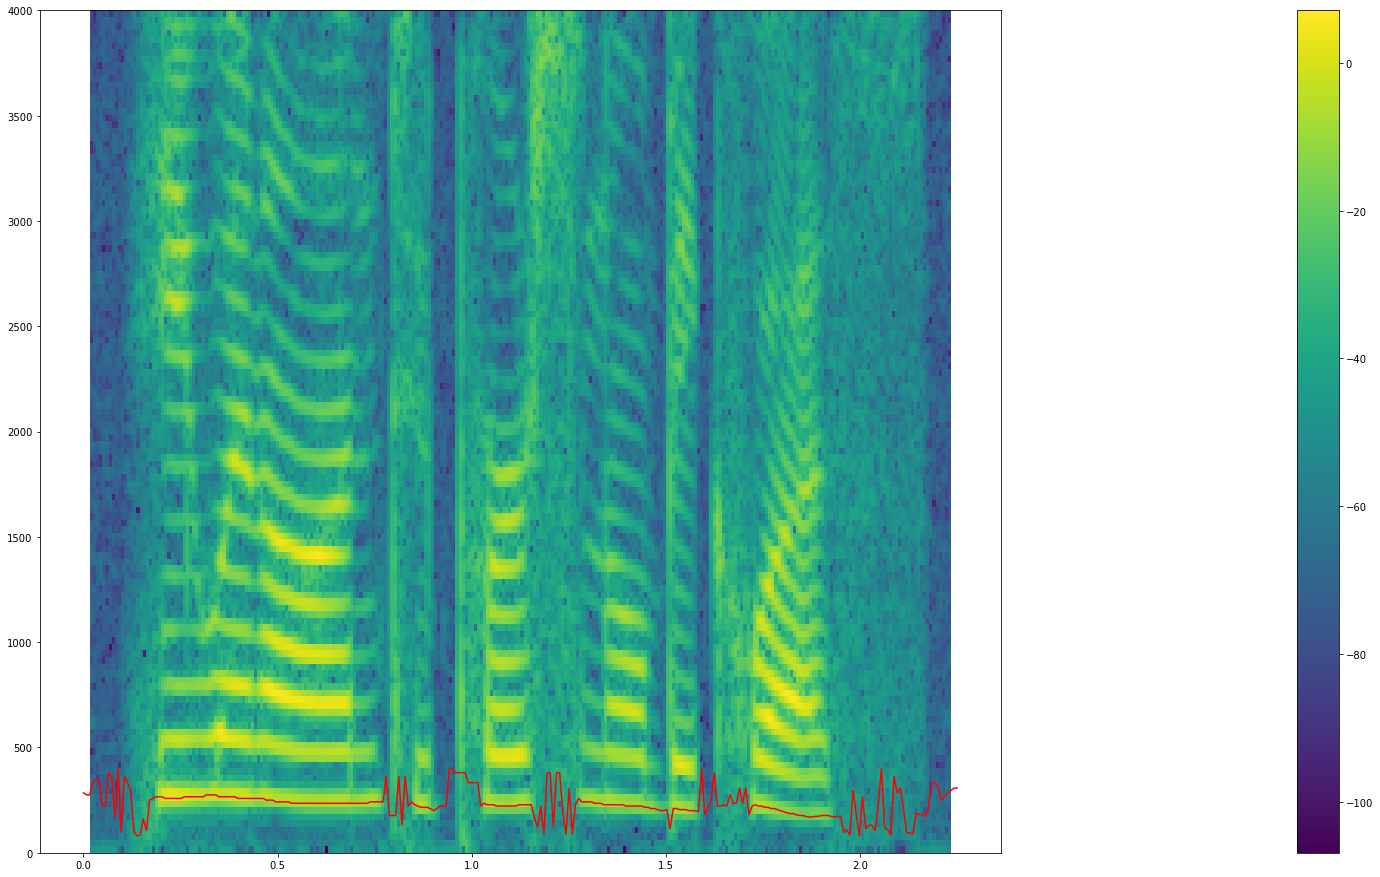

In [2593]:
fig = plt.figure()
fig.set_size_inches(26.5, 15.5)
ax = fig.add_subplot(111)
im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
               cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                       sampling_rate//2], aspect='auto')
fig.colorbar(im, orientation="vertical", pad=0.2)
ax.plot(np.linspace(0, speech_data.shape[0]/sampling_rate, num=fundamental_freqs.shape[0], dtype=np.float32), fundamental_freqs, c='r', linewidth=1.5)

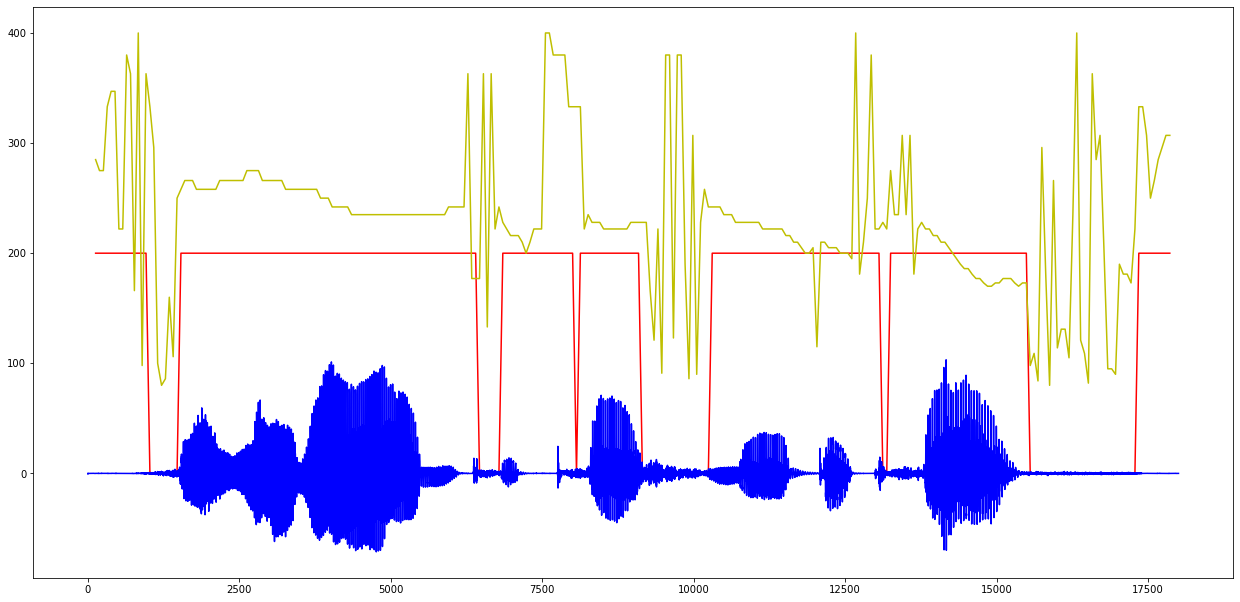

In [2594]:
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.plot(np.array(v_time_frame*sampling_rate, dtype=np.int32), voiced_unvoiced*200, c='r')
plt.plot(np.array(v_time_frame*sampling_rate, dtype=np.int32), fundamental_freqs, c='y')
plt.plot(np.arange(speech_data.shape[0]), speech_data*1000, c='b')
plt.show()

In [2595]:
#2.5.a)
m_frames.shape

(278, 256)

In [2596]:
#2.5.b)
from scipy.linalg import solve_toeplitz
import librosa



def lpc(m_frame: np.ndarray, M: int) -> np.ndarray:
    m_frame_analysis = m_frame*analysis_window
    autocorr_full = np.correlate(m_frame_analysis, m_frame_analysis, mode='full')
    autocorr = autocorr_full[len(m_frame_analysis)-1:len(m_frame_analysis)+M]
    coefficients = solve_toeplitz((-1)*autocorr[:-1], autocorr[1:])
    return coefficients

def compute_lpc(m_frames: np.ndarray, M: int) -> np.ndarray:
    m_lpc = np.zeros((m_frames.shape[0], M))
    for i in range(m_frames.shape[0]):
        m_lpc[i] = lpc(m_frames[i], M)
    return m_lpc

In [2597]:
#2.5.c) The order M of the LPC are chosen with respect to the bandwidth of the signal. 1 coefficient is used for every 1000Hz of the sampling rate. And then typically 2-4 more coefficients are added to better fit the signal. So, for an audio bandwidth of 4kHz, the order M would be 6-8.

M = 8

m_lpc = compute_lpc(m_frames, M)

In [2598]:
m_lpc.shape

(278, 8)

In [2599]:
m_lpc

array([[-0.48480352, -0.08877985, -0.09608857, ...,  0.07909403,
        -0.0591504 , -0.00951694],
       [-0.32393461, -0.10189708, -0.23532718, ...,  0.02422038,
        -0.0636873 ,  0.04475632],
       [-0.24553832,  0.06628103, -0.30514277, ..., -0.07158148,
        -0.14859201,  0.05263047],
       ...,
       [-0.33283113, -0.08350229, -0.20974923, ...,  0.02969347,
        -0.10359454, -0.06138117],
       [-0.39762404, -0.13952387, -0.28491869, ...,  0.16302971,
        -0.08526127, -0.11962726],
       [-0.33028678, -0.17122145, -0.19662507, ...,  0.11640997,
        -0.04399617, -0.12424524]])

In [2600]:
#3.1.a)
fund_period = 100
fund_period_samples = sampling_rate // fund_period

num_samples = speech_data.shape[0]

unvoiced_ex = np.random.randn(num_samples)
voiced_ex = np.zeros(num_samples)
voiced_ex[::fund_period_samples] = 1
voiced_ex

array([1., 0., 0., ..., 0., 0., 0.])

In [2601]:
m_frames.shape

(278, 256)

In [2602]:
#3.1.b)
def segment_signal(signal, R):
    segments = np.zeros((m_frames.shape[0], R))
    for i in range(segments.shape[0]):
        segments[i] = signal[i*R:(i+1)*R]
    return segments

In [2603]:
unvoiced_ex.shape

(18000,)

In [2604]:
voiced_ex

array([1., 0., 0., ..., 0., 0., 0.])

In [2605]:
frame_shift_samples = int(frame_shift / millis_per_sample)

unvoiced_ex_segments = segment_signal(unvoiced_ex, frame_shift_samples)
unvoiced_ex_segments

array([[-0.6611694 ,  0.45308238, -0.10643239, ..., -0.4514339 ,
        -1.400042  , -1.09656211],
       [-0.30309527,  0.1489716 , -1.28771428, ..., -1.91055286,
         1.82801169, -0.70947055],
       [-0.59659875, -0.28645085, -1.38001555, ..., -0.87630278,
        -2.19913436,  0.99638489],
       ...,
       [-1.91950524, -0.66252169, -0.19176375, ..., -0.15471515,
         0.09347617, -1.54708992],
       [-0.23885914, -0.38471586,  0.7398721 , ...,  1.96218787,
        -0.10083349,  0.72147443],
       [-0.45412322, -1.13918128,  0.73647764, ...,  0.37859434,
         0.52036796,  0.32817874]])

In [2606]:
frame_shift_samples

64

In [2607]:
voiced_ex

array([1., 0., 0., ..., 0., 0., 0.])

In [2608]:
voiced_ex_segments = segment_signal(voiced_ex, frame_shift_samples)
voiced_ex_segments

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2609]:
np.concatenate(([1.0], m_lpc[0]))

array([ 1.        , -0.48480352, -0.08877985, -0.09608857,  0.05330871,
       -0.17005094,  0.07909403, -0.0591504 , -0.00951694])

In [2610]:
#3.1.c)
from filteradaptively import filter_adaptively

def lpc_filter_adaptively(signal: np.ndarray, m_lpc: np.ndarray) -> np.ndarray:
    signal_filtered = np.zeros(signal.shape, dtype=np.float64)
    filter_state = None
    for i in range(signal.shape[0]):
        #cur_lpcs = m_lpc[i] if i < m_lpc.shape[0] else cur_lpcs
        signal_filtered[i], filter_state = filter_adaptively(ma_coeff=np.array([1]),
                                                             ar_coeff=np.concatenate(([1.0], m_lpc[i])), signal=signal[i], filter_state_in=filter_state)
    return signal_filtered

In [2611]:
voiced_ex_segment_filtered = lpc_filter_adaptively(voiced_ex_segments, m_lpc)
unvoiced_ex_segment_filtered = lpc_filter_adaptively(unvoiced_ex_segments, m_lpc)

In [2612]:
voiced_ex_segment_filtered

array([[1.00000000e+00, 4.84803525e-01, 3.23814311e-01, ...,
        4.34288786e-04, 3.88286402e-04, 3.47150437e-04],
       [3.10370987e-04, 2.27564616e-04, 1.91350559e-04, ...,
        1.84753971e-02, 1.72782309e-02, 1.61634568e-02],
       [1.51169453e-02, 1.29548912e-02, 9.28421772e-03, ...,
        1.40232052e-01, 1.37254481e-01, 1.33841156e-01],
       ...,
       [1.01488474e+00, 3.45550811e-01, 2.06941482e-01, ...,
        9.06870839e-03, 8.55773555e-03, 8.07555711e-03],
       [7.62054941e-03, 7.68493404e-03, 7.87517731e-03, ...,
        5.33586379e-03, 4.62056376e-03, 4.66713903e-03],
       [3.87579140e-03, 3.44495984e-03, 3.24334072e-03, ...,
        5.64965128e-03, 3.46862283e-03, 4.16264628e-03]])

In [2613]:
def reconstruct_signal(signal_segments: np.ndarray) -> np.ndarray:
    signal_reconstructed = np.concatenate(signal_segments)
    return signal_reconstructed

In [2614]:
voiced_ex_reconstructed = reconstruct_signal(voiced_ex_segment_filtered)
unvoiced_ex_reconstructed = reconstruct_signal(unvoiced_ex_segment_filtered)

In [2615]:
voiced_ex_reconstructed.shape

(17792,)

In [2616]:
unvoiced_ex_reconstructed.shape

(17792,)

In [2617]:
sd.play(voiced_ex_reconstructed, sampling_rate)

In [2618]:
sd.play(unvoiced_ex_reconstructed, sampling_rate)

In [2619]:
def plot_spectrogram(signal):
    m_stft, v_freq, v_time_frame = compute_stft(signal, sampling_rate, frame_length, frame_shift, analysis_window)

    fig = plt.figure()
    fig.set_size_inches(26.5, 15.5)
    ax = fig.add_subplot(111)
    im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
                   cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                           sampling_rate//2], aspect='auto')
    fig.colorbar(im, orientation="vertical", pad=0.2)

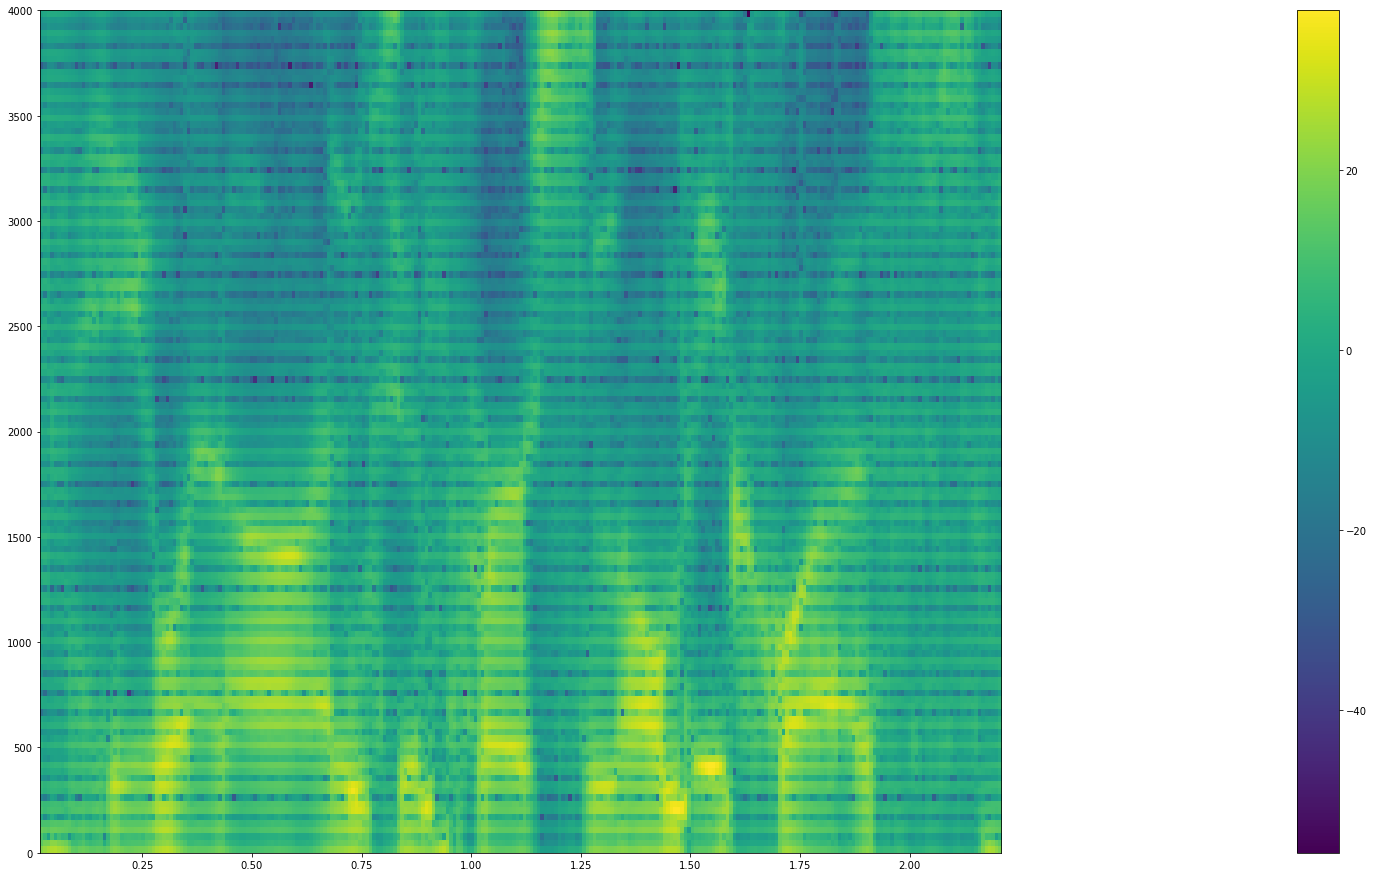

In [2620]:
plot_spectrogram(voiced_ex_reconstructed)

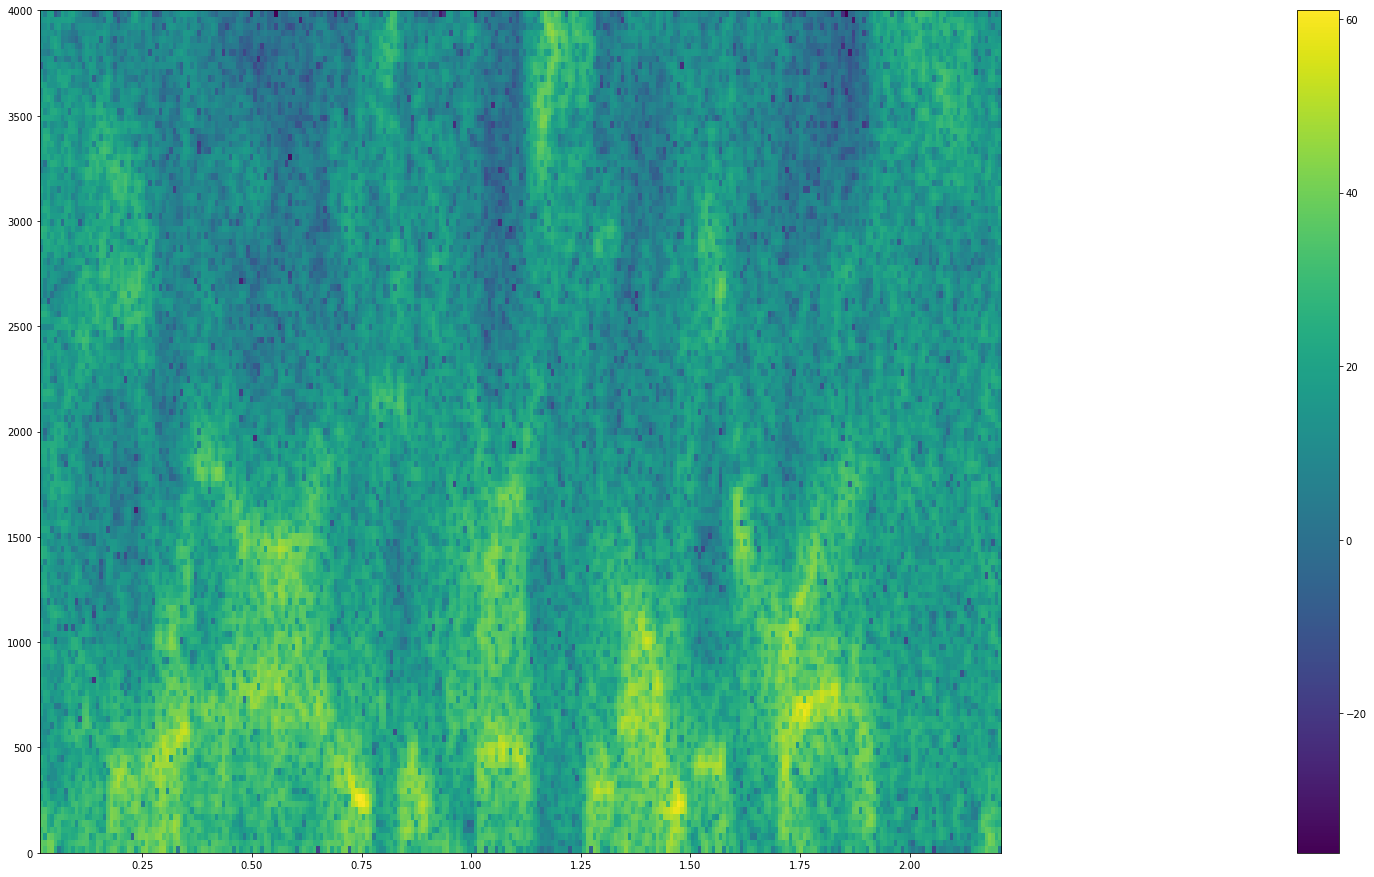

In [2621]:
plot_spectrogram(unvoiced_ex_reconstructed)

In [2622]:
#3.2)
voiced_unvoiced

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [2623]:
voiced_ex_segments.shape

(278, 64)

In [2624]:
switched_ex = np.zeros(voiced_ex_segments.shape)

for i in range(voiced_unvoiced.shape[0]):
    if voiced_unvoiced[i] == 1:
        switched_ex[i] = voiced_ex_segments[i]
    else:
        switched_ex[i] = unvoiced_ex_segments[i]

In [2625]:
switched_ex

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2626]:
switched_ex_filtered = lpc_filter_adaptively(switched_ex, m_lpc)

In [2627]:
switched_ex_filtered

array([[1.00000000e+00, 4.84803525e-01, 3.23814311e-01, ...,
        4.34288786e-04, 3.88286402e-04, 3.47150437e-04],
       [3.10370987e-04, 2.27564616e-04, 1.91350559e-04, ...,
        1.84753971e-02, 1.72782309e-02, 1.61634568e-02],
       [1.51169453e-02, 1.29548912e-02, 9.28421772e-03, ...,
        1.40232052e-01, 1.37254481e-01, 1.33841156e-01],
       ...,
       [1.01488474e+00, 3.45550811e-01, 2.06941482e-01, ...,
        9.06870839e-03, 8.55773555e-03, 8.07555711e-03],
       [7.62054941e-03, 7.68493404e-03, 7.87517731e-03, ...,
        5.33586379e-03, 4.62056376e-03, 4.66713903e-03],
       [3.87579140e-03, 3.44495984e-03, 3.24334072e-03, ...,
        5.64965128e-03, 3.46862283e-03, 4.16264628e-03]])

In [2628]:
switched_ex_reconstructed = reconstruct_signal(switched_ex_filtered)

In [2629]:
switched_ex_reconstructed

array([1.        , 0.48480352, 0.32381431, ..., 0.00564965, 0.00346862,
       0.00416265])

In [2630]:
sd.play(switched_ex_reconstructed, sampling_rate)

In [2631]:
#3.3.a)
powers

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2632]:
powers_switched_filtered = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_switched_filtered[i] = compute_power(switched_ex_filtered[i])

In [2633]:
powers_switched_filtered

array([2.71100415e-02, 2.98420990e-02, 3.36597442e-02, 3.35385369e-02,
       1.38816900e-02, 6.66991400e-02, 5.23433831e-02, 3.97432337e-02,
       3.19865242e-02, 5.88889645e-03, 2.99467994e-02, 2.80267586e-02,
       2.96970367e-02, 4.19541152e-02, 4.75167300e+00, 1.71531879e+00,
       1.66664440e+00, 1.77113793e+00, 2.65552340e+00, 1.60978385e+00,
       2.73384075e+00, 4.13319197e+00, 3.02916903e+00, 2.52967656e-01,
       5.59331064e-02, 1.50536233e-01, 1.11886694e-01, 9.54181473e-02,
       9.19447283e-02, 1.07366016e-02, 9.11453583e-02, 8.23990550e-02,
       1.02223959e-01, 1.47740592e-01, 1.40123228e-02, 6.13383948e-01,
       9.38559733e-01, 1.11948360e+00, 1.00853439e+00, 1.41891597e-01,
       7.86664824e-01, 6.55499210e-01, 4.41872144e-01, 2.40561053e-01,
       1.94903196e-02, 8.50340762e-02, 8.70142217e-02, 8.72701168e-02,
       8.03580310e-02, 8.80295668e-03, 9.41351655e-02, 1.18459212e-01,
       1.66223744e-01, 1.76932571e-01, 6.99873055e-03, 1.46919856e-01,
      

In [2634]:
powers

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2635]:
g = np.zeros(powers.shape)
for i in range(powers.shape[0]):
    g[i] = np.sqrt(powers[i] / np.maximum(powers_switched_filtered[i], 10**(-30)))

In [2636]:
g

array([3.29080205e-04, 2.78666726e-04, 2.68495860e-04, 3.04359570e-04,
       4.83494278e-04, 2.32608618e-04, 2.53964595e-04, 2.53674110e-04,
       2.86758108e-04, 7.22078388e-04, 4.19989259e-04, 7.12413309e-04,
       1.18826371e-03, 1.38714369e-03, 1.83376179e-04, 4.23649795e-04,
       5.52389109e-04, 6.78129301e-04, 6.39745912e-04, 9.88492945e-04,
       1.19483384e-03, 3.33980110e-03, 6.21169795e-03, 2.85337697e-02,
       7.54965306e-02, 5.14410928e-02, 6.34225160e-02, 6.97441473e-02,
       6.86918028e-02, 1.87815116e-01, 5.76427913e-02, 5.36397123e-02,
       4.22558896e-02, 3.13639342e-02, 9.50110736e-02, 1.38200289e-02,
       1.13090874e-02, 1.10593769e-02, 1.29304158e-02, 4.07281369e-02,
       2.28498643e-02, 2.89948541e-02, 3.73613652e-02, 5.18625300e-02,
       1.72515787e-01, 8.12525928e-02, 8.28285013e-02, 8.57464672e-02,
       8.95441816e-02, 2.58339557e-01, 7.08557653e-02, 5.17647083e-02,
       3.42762318e-02, 2.69658045e-02, 1.62398421e-01, 4.79646166e-02,
      

In [2637]:
def apply_gain(signal, g):
    scaled_signal = np.zeros(signal.shape)
    for i in range(g.shape[0]):
        scaled_signal[i] = np.multiply(signal[i], g[i])
    return scaled_signal

In [2638]:
switched_ex_filtered

array([[1.00000000e+00, 4.84803525e-01, 3.23814311e-01, ...,
        4.34288786e-04, 3.88286402e-04, 3.47150437e-04],
       [3.10370987e-04, 2.27564616e-04, 1.91350559e-04, ...,
        1.84753971e-02, 1.72782309e-02, 1.61634568e-02],
       [1.51169453e-02, 1.29548912e-02, 9.28421772e-03, ...,
        1.40232052e-01, 1.37254481e-01, 1.33841156e-01],
       ...,
       [1.01488474e+00, 3.45550811e-01, 2.06941482e-01, ...,
        9.06870839e-03, 8.55773555e-03, 8.07555711e-03],
       [7.62054941e-03, 7.68493404e-03, 7.87517731e-03, ...,
        5.33586379e-03, 4.62056376e-03, 4.66713903e-03],
       [3.87579140e-03, 3.44495984e-03, 3.24334072e-03, ...,
        5.64965128e-03, 3.46862283e-03, 4.16264628e-03]])

In [2639]:
switched_ex_filtered_scaled = apply_gain(switched_ex_filtered, g)
switched_ex_filtered_scaled

array([[3.29080205e-04, 1.59539243e-04, 1.06560880e-04, ...,
        1.42915842e-07, 1.27777369e-07, 1.14240337e-07],
       [8.64900667e-08, 6.34146864e-08, 5.33230339e-08, ...,
        5.14847843e-06, 4.81486803e-06, 4.50421759e-06],
       [4.05883724e-06, 3.47833464e-06, 2.49277402e-06, ...,
        3.76517253e-05, 3.68522598e-05, 3.59357962e-05],
       ...,
       [2.91370515e-04, 9.92066524e-05, 5.94123093e-05, ...,
        2.60360031e-06, 2.45690147e-06, 2.31846941e-06],
       [2.11797241e-06, 2.13586678e-06, 2.18874092e-06, ...,
        1.48299180e-06, 1.28418911e-06, 1.29713374e-06],
       [1.16968418e-06, 1.03966251e-06, 9.78815406e-07, ...,
        1.70502152e-06, 1.04680382e-06, 1.25625479e-06]])

In [2640]:
powers_switched_filtered_scaled = np.zeros(switched_ex_filtered_scaled.shape[0])
for i in range(switched_ex_filtered_scaled.shape[0]):
    powers_switched_filtered_scaled[i] = compute_power(switched_ex_filtered_scaled[i])

In [2641]:
powers_switched_filtered_scaled

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2642]:
powers

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

3.3.b) To pick the best g, we use the following formula: $g = \sqrt{\frac{P2}{P1}}$ where P2 is the power of the signal we want to match.

In [2643]:
#3.3.c)
switched_ex_scaled_reconstructed = reconstruct_signal(switched_ex_filtered_scaled)

In [2644]:
sd.play(switched_ex_scaled_reconstructed, sampling_rate)

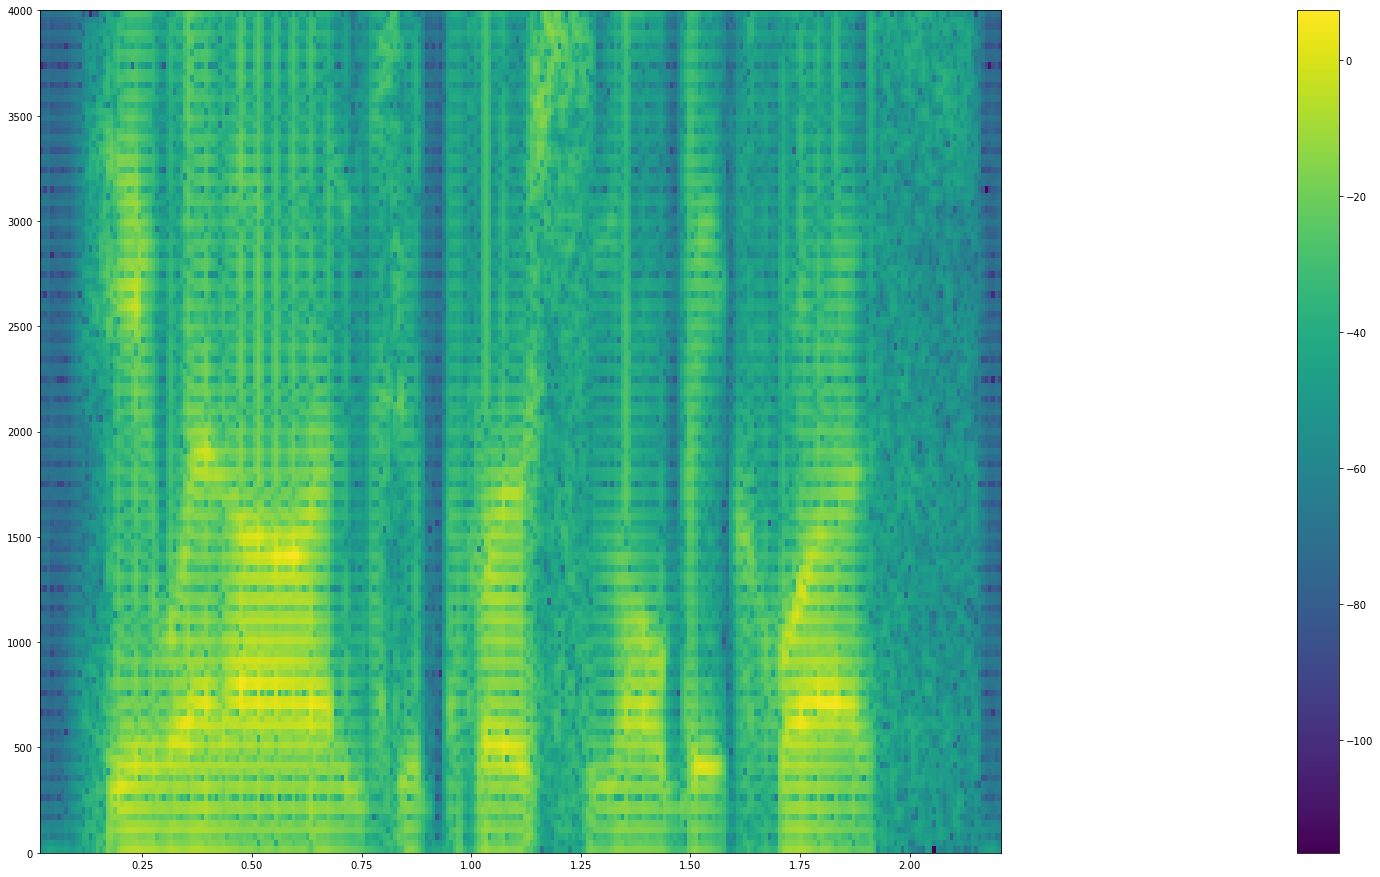

In [2645]:
#3.3.d)
plot_spectrogram(switched_ex_scaled_reconstructed)

In [2646]:
fundamental_freqs

array([285, 275, 275, 333, 347, 347, 222, 222, 380, 363, 166, 400,  98,
       363, 333, 296, 100,  80,  86, 160, 106, 250, 258, 266, 266, 266,
       258, 258, 258, 258, 258, 258, 266, 266, 266, 266, 266, 266, 266,
       275, 275, 275, 275, 266, 266, 266, 266, 266, 266, 258, 258, 258,
       258, 258, 258, 258, 258, 258, 250, 250, 250, 242, 242, 242, 242,
       242, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       242, 242, 242, 242, 242, 363, 177, 177, 177, 363, 133, 363, 222,
       242, 228, 222, 216, 216, 216, 210, 200, 210, 222, 222, 222, 400,
       400, 380, 380, 380, 380, 333, 333, 333, 333, 222, 235, 228, 228,
       228, 222, 222, 222, 222, 222, 222, 222, 228, 228, 228, 228, 228,
       166, 121, 222,  91, 380, 380, 123, 380, 380, 190,  86, 307,  90,
       228, 258, 242, 242, 242, 242, 235, 235, 235, 228, 228, 228, 228,
       228, 228, 228, 222, 222, 222, 222, 222, 222, 216, 216, 21

In [2647]:
variable_f0_signal = np.zeros(voiced_ex_segments.shape)

In [2648]:
variable_f0_signal.shape

(278, 64)

In [2649]:
counter = 0

for i in range(fundamental_freqs.shape[0]):
    f0 = sampling_rate // fundamental_freqs[i]
    if voiced_unvoiced[i] == 1:
        for j in range(variable_f0_signal[i].shape[0]):
            counter = counter + 1
            if counter > f0:
                print(f'matched frequency {fundamental_freqs[i]} at index [{i}][{j}]')
                variable_f0_signal[i][j] = 1
                counter = 0
            else:
                variable_f0_signal[i][j] = 0
    else:
        variable_f0_signal[i] = unvoiced_ex_segments[i]
variable_f0_signal[0][0] = 1

matched frequency 285 at index [0][28]
matched frequency 285 at index [0][57]
matched frequency 275 at index [1][23]
matched frequency 275 at index [1][53]
matched frequency 275 at index [2][19]
matched frequency 275 at index [2][49]
matched frequency 333 at index [3][10]
matched frequency 333 at index [3][35]
matched frequency 333 at index [3][60]
matched frequency 347 at index [4][20]
matched frequency 347 at index [4][44]
matched frequency 347 at index [5][4]
matched frequency 347 at index [5][28]
matched frequency 347 at index [5][52]
matched frequency 222 at index [6][25]
matched frequency 222 at index [6][62]
matched frequency 222 at index [7][35]
matched frequency 380 at index [8][0]
matched frequency 380 at index [8][22]
matched frequency 380 at index [8][44]
matched frequency 363 at index [9][3]
matched frequency 363 at index [9][26]
matched frequency 363 at index [9][49]
matched frequency 166 at index [10][34]
matched frequency 400 at index [11][0]
matched frequency 400 at in

In [2650]:
variable_f0_signal

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2651]:
#variable_f0_signal = np.zeros(speech_data.shape[0])

In [2652]:
#variable_f0_signal[::int(np.mean(fundamental_freqs))] = 1

In [2653]:
#int(np.mean(fundamental_freqs))

In [2654]:
#variable_f0_signal

In [2655]:
#variable_f0_signal = segment_signal(variable_f0_signal, frame_shift_samples)

In [2656]:
#variable_f0_signal

In [2657]:
variable_f0_signal_filtered = lpc_filter_adaptively(variable_f0_signal, m_lpc)
variable_f0_signal_filtered

array([[1.        , 0.48480352, 0.32381431, ..., 0.17601199, 0.29119219,
        0.17423977],
       [0.18889175, 0.16016511, 0.10261407, ..., 0.25697207, 0.20199552,
        0.23974218],
       [0.1985583 , 0.18118972, 0.13114742, ..., 0.34858935, 0.34325497,
        0.30792618],
       ...,
       [0.15635392, 0.13364001, 1.13425235, ..., 0.36559102, 0.25449781,
        0.25179158],
       [0.19040552, 0.27356794, 0.31292489, ..., 0.15285848, 0.07351551,
        0.076441  ],
       [0.09813785, 0.04006135, 0.07596864, ..., 0.01234521, 0.01070547,
        0.00557112]])

In [2658]:
powers_variable_f0_signal_filtered = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_variable_f0_signal_filtered[i] = compute_power(variable_f0_signal_filtered[i])

In [2659]:
powers_variable_f0_signal_filtered

array([8.12343925e-02, 6.77287794e-02, 1.03764028e-01, 1.89883405e-01,
       2.61164675e-01, 5.00416253e-01, 2.08884967e-01, 1.09020055e-01,
       1.86570257e-01, 1.45643560e-01, 3.29274939e-02, 1.00231398e-01,
       1.24362118e-02, 1.37569591e-01, 4.75425994e+00, 1.71535839e+00,
       1.66664443e+00, 1.77113793e+00, 2.65552340e+00, 1.60978385e+00,
       2.73384075e+00, 4.13319197e+00, 2.14501096e+00, 7.74570501e-01,
       4.18437903e-01, 3.05713821e-01, 1.98462396e-01, 1.59500444e-01,
       1.61419833e-01, 1.71003346e-01, 1.67325360e-01, 1.48765478e-01,
       1.83140907e-01, 2.71609202e-01, 5.18071939e-01, 1.10687120e+00,
       1.79719235e+00, 2.54939101e+00, 2.78992686e+00, 2.27498614e+00,
       2.22780301e+00, 2.15012258e+00, 1.65365560e+00, 4.96325824e-01,
       2.06347577e-01, 1.42731944e-01, 1.51749064e-01, 1.79905472e-01,
       1.60955598e-01, 1.61054947e-01, 1.66437842e-01, 2.09766448e-01,
       2.95226593e-01, 3.67767304e-01, 4.31841828e-01, 3.00202812e-01,
      

In [2660]:
g = np.zeros(powers.shape)
for i in range(powers.shape[0]):
    g[i] = np.sqrt(powers[i] / np.maximum(powers_variable_f0_signal_filtered[i], 10**(-30)))

In [2661]:
variable_f0_signal_filtered_scaled = apply_gain(variable_f0_signal_filtered, g)
variable_f0_signal_filtered_scaled

array([[1.90106463e-04, 9.21642832e-05, 6.15591932e-05, ...,
        3.34610161e-05, 5.53575180e-05, 3.31241058e-05],
       [3.49402628e-05, 2.96265512e-05, 1.89810436e-05, ...,
        4.75334238e-05, 3.73641329e-05, 4.43463243e-05],
       [3.03639050e-05, 2.77078697e-05, 2.00553082e-05, ...,
        5.33069344e-05, 5.24911899e-05, 4.70886467e-05],
       ...,
       [2.32987987e-05, 1.99141266e-05, 1.69018578e-04, ...,
        5.44778901e-05, 3.79235350e-05, 3.75202710e-05],
       [3.32527899e-05, 4.77764363e-05, 5.46498092e-05, ...,
        2.66955009e-05, 1.28388908e-05, 1.33498050e-05],
       [2.05230706e-05, 8.37782667e-06, 1.58869368e-05, ...,
        2.58169086e-06, 2.23878155e-06, 1.16506027e-06]])

In [2662]:
powers_variable_f0_signal_filtered_scaled = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_variable_f0_signal_filtered_scaled[i] = compute_power(variable_f0_signal_filtered_scaled[i])

In [2663]:
powers_variable_f0_signal_filtered_scaled

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2664]:
powers

array([2.93584890e-09, 2.31739250e-09, 2.42653186e-09, 3.10683390e-09,
       3.24507710e-09, 3.60887498e-09, 3.37604433e-09, 2.55749910e-09,
       2.63025868e-09, 3.07045411e-09, 5.28234523e-09, 1.42244971e-08,
       4.19313437e-08, 8.07267497e-08, 1.59783667e-07, 3.07863957e-07,
       5.08549419e-07, 8.14474333e-07, 1.08683889e-06, 1.57294926e-06,
       3.90290734e-06, 4.61027448e-05, 1.16881067e-04, 2.05960197e-04,
       3.18803388e-04, 3.98346878e-04, 4.50054777e-04, 4.64137349e-04,
       4.33847064e-04, 3.78728448e-04, 3.02847897e-04, 2.37080105e-04,
       1.82527034e-04, 1.45331884e-04, 1.26490697e-04, 1.17152162e-04,
       1.20037526e-04, 1.36923834e-04, 1.68622566e-04, 2.35367104e-04,
       4.10730525e-04, 5.51079211e-04, 6.16796780e-04, 6.47042361e-04,
       5.80064981e-04, 5.61393597e-04, 5.96966343e-04, 6.41649749e-04,
       6.44323587e-04, 5.87503400e-04, 4.72609314e-04, 3.17421531e-04,
       1.95289638e-04, 1.28657335e-04, 1.84579250e-04, 3.38004473e-04,
      

In [2665]:
variable_f0_signal_improved = reconstruct_signal(variable_f0_signal_filtered_scaled)

In [2666]:
#3.4.e)

In [2667]:
sd.play(variable_f0_signal_improved, sampling_rate)

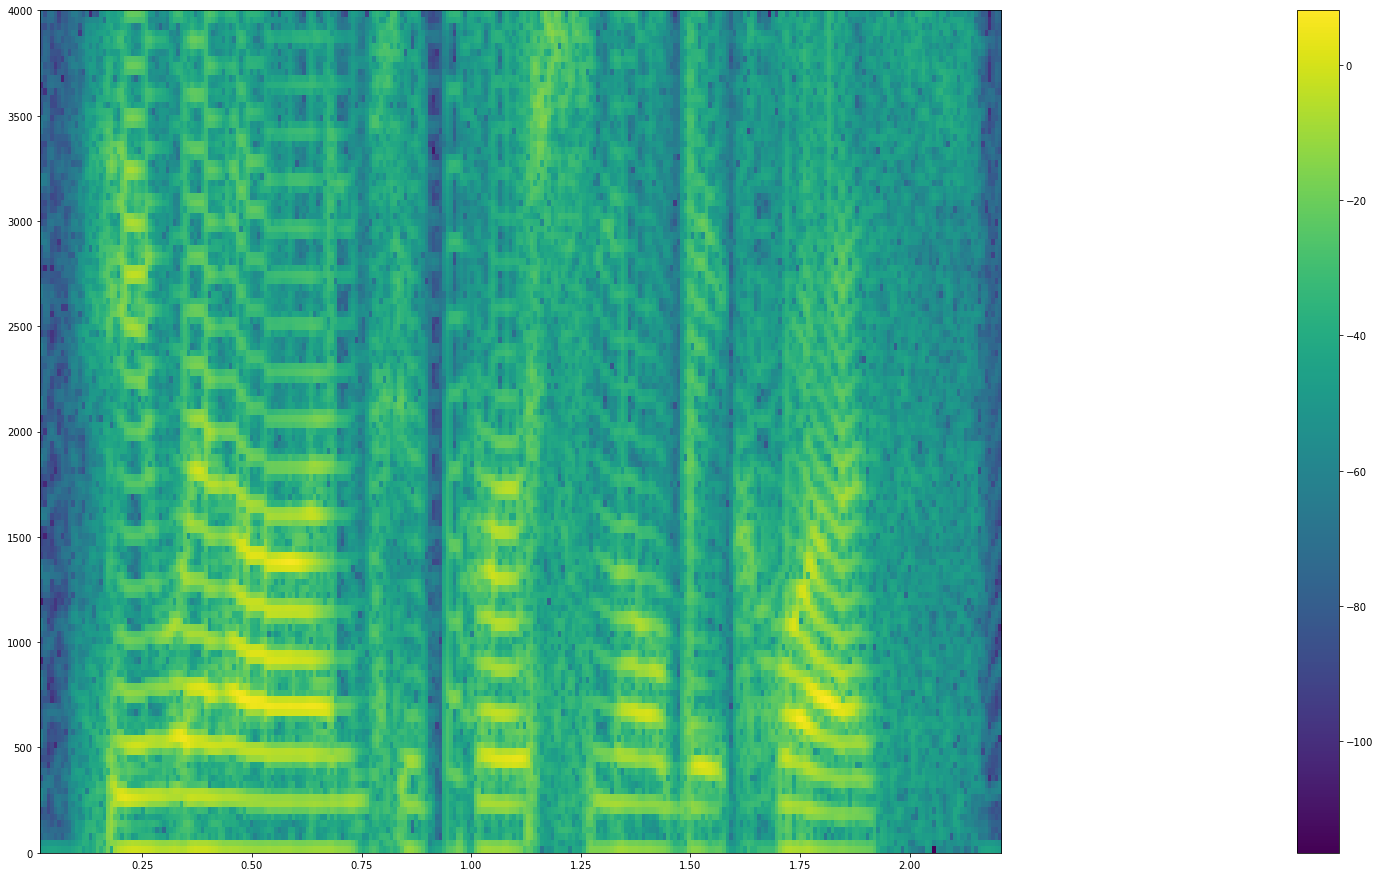

In [2668]:
#3.4.f)
plot_spectrogram(variable_f0_signal_improved)

#3.5.a) if the LPC synthesis step is left out then the formants of the speech signal are not taken into consideration and the speech signal won't be intelligible.
This is because only the excitation signal is being considered, which results in either a noise signal or a pure tone.

In [2669]:
#3.5.b)
powers_variable_f0_signal = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_variable_f0_signal[i] = compute_power(variable_f0_signal[i])

g = np.zeros(powers.shape)
for i in range(powers.shape[0]):
    g[i] = np.sqrt(powers[i] / np.maximum(powers_variable_f0_signal[i], 10**(-30)))

variable_f0_signal_scaled = apply_gain(variable_f0_signal, g)

variable_f0_signal_scaled_reconstructed = np.concatenate(variable_f0_signal_scaled)

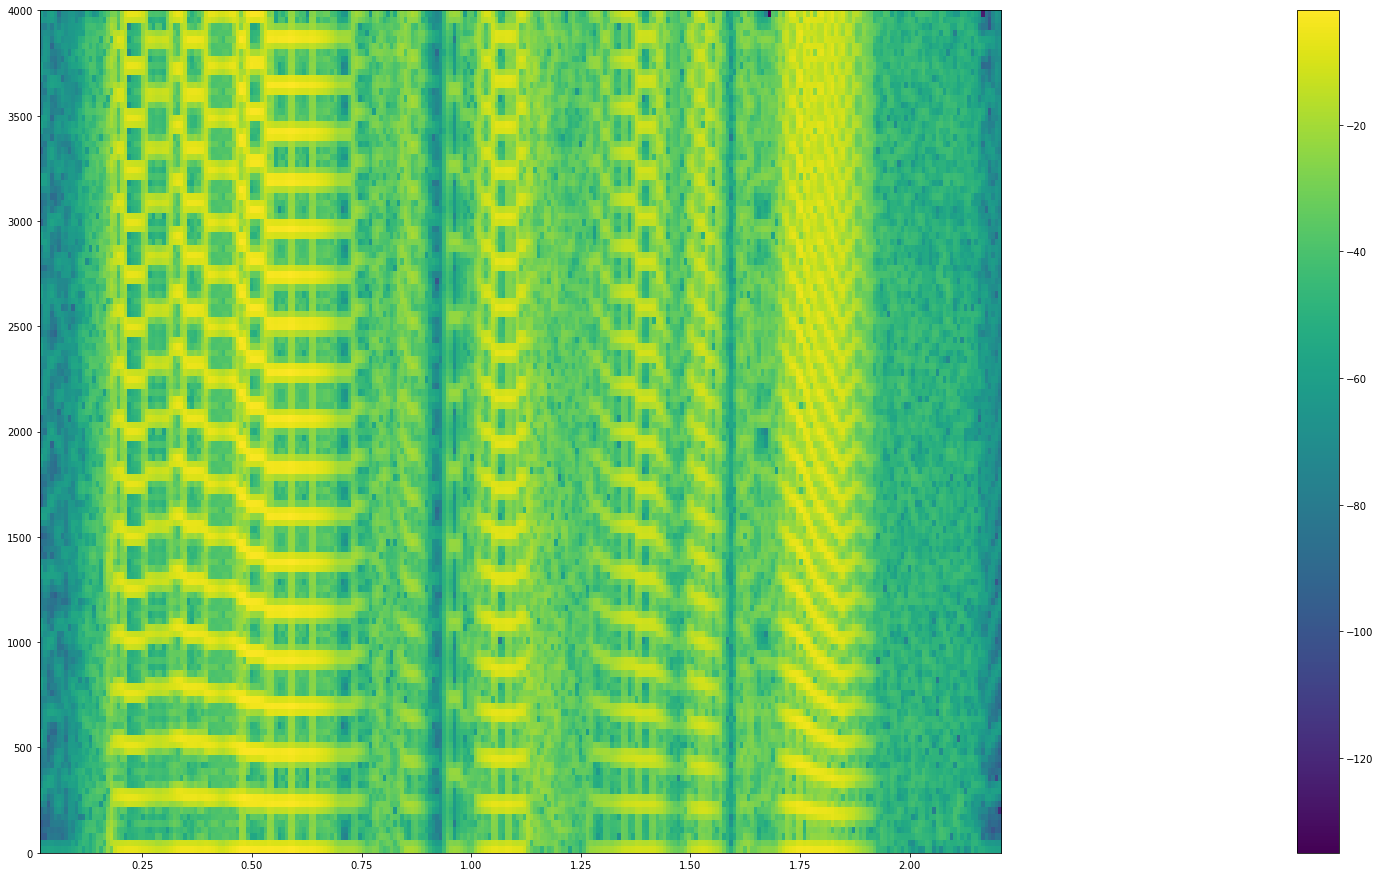

In [2670]:
plot_spectrogram(variable_f0_signal_scaled_reconstructed)

In [2671]:
#3.5.c)
sd.play(variable_f0_signal_scaled_reconstructed, sampling_rate)

In [2672]:
#3.5.d)

In [2673]:
#3.5.e)

In [2674]:
#4.1.a)
def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    x_max = x_center+(x_range/2)
    x_min = x_center-(x_range/2)
    step = (x_max)/(2**(num_bits-1))
    print("the step is: ", step)
    quantized_idxs = np.minimum(np.floor(((x - x_min) / step)), ((2**num_bits) - 1))

    return quantized_idxs

4.1.b) $2^{n}$ quantization levels.

4.1.c) x_center should be set to midpoint between x_min and x_max: $\frac{x_{max} + x_{min}}{2}$. The expected numbrt of quantization levels is 4.
The step size is $\frac{x_{max}}{2^{n-1}}$, in this case 1.0.

In [2675]:
x = np.array([-2,-1,0,1,2])
x_range = 4
num_bits = 2
x_center = int((np.max(x) + np.min(x))/2)
quantized_signal = quantize_encoder(x, num_bits, x_range, x_center)

the step is:  1.0


In [2676]:
quantized_signal

array([0., 1., 2., 3., 3.])

In [2677]:
def quantize_decoder(quant_idxs: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    x_max = x_center+(x_range/2)
    x_min = x_center-(x_range/2)
    step = (x_max)/(2**(num_bits-1))
    quantized_x = np.clip(x_min+((quant_idxs+1/2)*step), a_min=(x_min+0.5*step), a_max=x_max)
    return quantized_x

In [2678]:
quantize_decoder(quantized_signal, num_bits, x_range, x_center)

array([-1.5, -0.5,  0.5,  1.5,  1.5])

In [2679]:
ramp = np.linspace(-5, 5, 1000)
ramp

array([-5.        , -4.98998999, -4.97997998, -4.96996997, -4.95995996,
       -4.94994995, -4.93993994, -4.92992993, -4.91991992, -4.90990991,
       -4.8998999 , -4.88988989, -4.87987988, -4.86986987, -4.85985986,
       -4.84984985, -4.83983984, -4.82982983, -4.81981982, -4.80980981,
       -4.7997998 , -4.78978979, -4.77977978, -4.76976977, -4.75975976,
       -4.74974975, -4.73973974, -4.72972973, -4.71971972, -4.70970971,
       -4.6996997 , -4.68968969, -4.67967968, -4.66966967, -4.65965966,
       -4.64964965, -4.63963964, -4.62962963, -4.61961962, -4.60960961,
       -4.5995996 , -4.58958959, -4.57957958, -4.56956957, -4.55955956,
       -4.54954955, -4.53953954, -4.52952953, -4.51951952, -4.50950951,
       -4.4994995 , -4.48948949, -4.47947948, -4.46946947, -4.45945946,
       -4.44944945, -4.43943944, -4.42942943, -4.41941942, -4.40940941,
       -4.3993994 , -4.38938939, -4.37937938, -4.36936937, -4.35935936,
       -4.34934935, -4.33933934, -4.32932933, -4.31931932, -4.30

In [2680]:
x_range = 6
x_center = 0
num_bits = 2

quantized_idxs = quantize_encoder(ramp, num_bits, x_range, x_center)
quantized_signal = quantize_decoder(quantized_idxs, num_bits, x_range, x_center)
quantized_signal

the step is:  1.5


array([-2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25, -2.25,
       -2.25, -2.25,

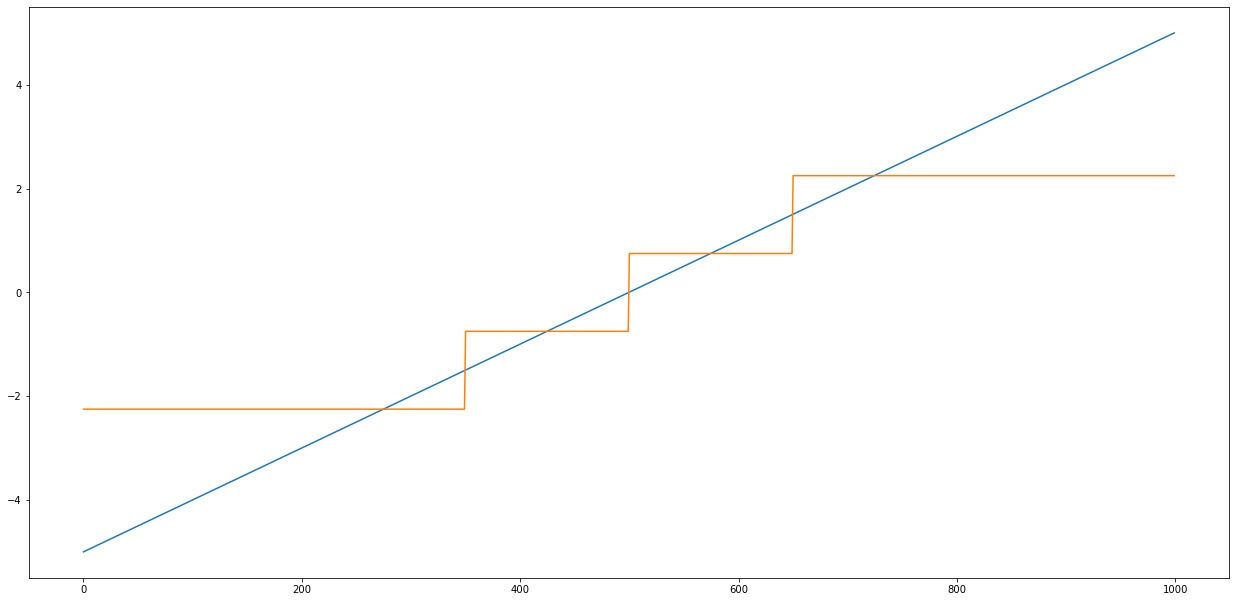

In [2681]:
fig, ax = plt.subplots()
fig.set_size_inches(21.5, 10.5)
ax.plot(ramp)
ax.plot(quantized_signal)

In [2682]:
x_range = 6
x_center = 1
num_bits = 2

quantized_idxs = quantize_encoder(ramp, num_bits, x_range, x_center)
quantized_signal = quantize_decoder(quantized_idxs, num_bits, x_range, x_center)

the step is:  2.0


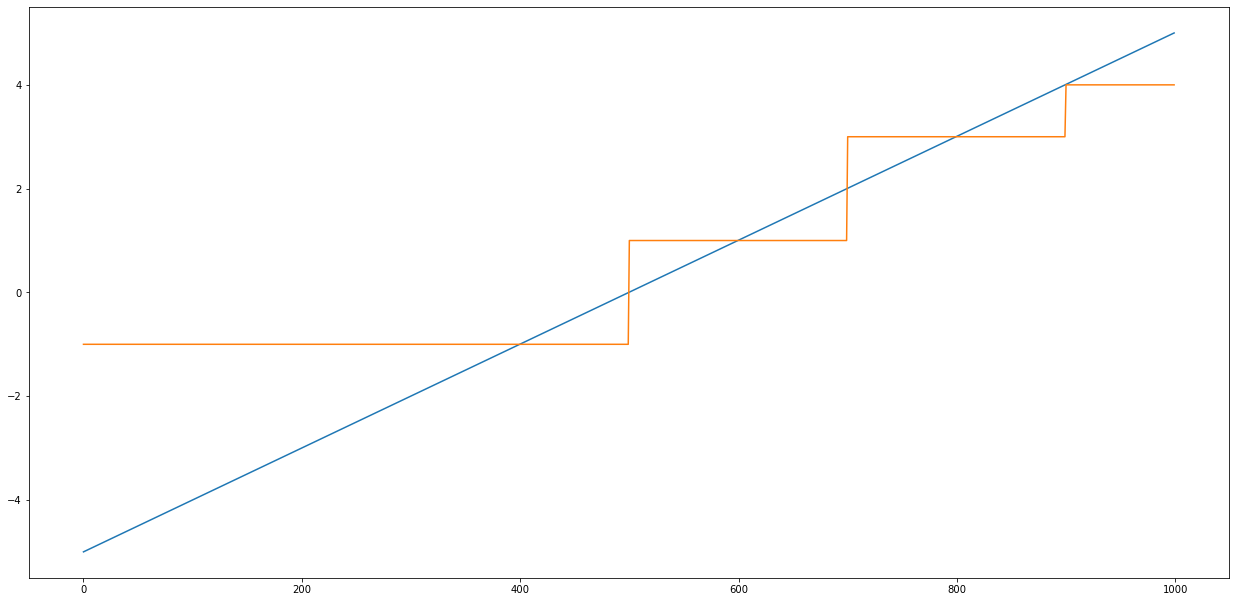

In [2683]:
fig, ax = plt.subplots()
fig.set_size_inches(21.5, 10.5)
ax.plot(ramp)
ax.plot(quantized_signal)

If a signal has many values around zero and we want to quantize it with a small number of bits, then it is better to set the x_center to zero.

In [2684]:
#4.2
freq_x_range = (np.max(fundamental_freqs) - np.min(fundamental_freqs))
freq_x_center = (np.max(fundamental_freqs) + np.min(fundamental_freqs))/2
print(freq_x_range)
print(freq_x_center)

320
240.0


In [2685]:
fundamental_freqs

array([285, 275, 275, 333, 347, 347, 222, 222, 380, 363, 166, 400,  98,
       363, 333, 296, 100,  80,  86, 160, 106, 250, 258, 266, 266, 266,
       258, 258, 258, 258, 258, 258, 266, 266, 266, 266, 266, 266, 266,
       275, 275, 275, 275, 266, 266, 266, 266, 266, 266, 258, 258, 258,
       258, 258, 258, 258, 258, 258, 250, 250, 250, 242, 242, 242, 242,
       242, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235,
       242, 242, 242, 242, 242, 363, 177, 177, 177, 363, 133, 363, 222,
       242, 228, 222, 216, 216, 216, 210, 200, 210, 222, 222, 222, 400,
       400, 380, 380, 380, 380, 333, 333, 333, 333, 222, 235, 228, 228,
       228, 222, 222, 222, 222, 222, 222, 222, 228, 228, 228, 228, 228,
       166, 121, 222,  91, 380, 380, 123, 380, 380, 190,  86, 307,  90,
       228, 258, 242, 242, 242, 242, 235, 235, 235, 228, 228, 228, 228,
       228, 228, 228, 222, 222, 222, 222, 222, 222, 216, 216, 21

In [2686]:
freq_quantized_idxs = quantize_encoder(fundamental_freqs, 6, freq_x_range, freq_x_center)
freq_quantized_idxs

the step is:  12.5


array([16., 15., 15., 20., 21., 21., 11., 11., 24., 22.,  6., 25.,  1.,
       22., 20., 17.,  1.,  0.,  0.,  6.,  2., 13., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       15., 15., 15., 15., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 13., 13., 13., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 22.,  7.,  7.,  7., 22.,  4., 22., 11.,
       12., 11., 11., 10., 10., 10., 10.,  9., 10., 11., 11., 11., 25.,
       25., 24., 24., 24., 24., 20., 20., 20., 20., 11., 12., 11., 11.,
       11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        6.,  3., 11.,  0., 24., 24.,  3., 24., 24.,  8.,  0., 18.,  0.,
       11., 14., 12., 12., 12., 12., 12., 12., 12., 11., 11., 11., 11.,
       11., 11., 11., 11., 11., 11., 11., 11., 11., 10., 10., 10

In [2687]:
freq_quantized_signal = quantize_decoder(freq_quantized_idxs, 6, freq_x_range, freq_x_center).astype(int)

In [2688]:
freq_quantized_signal

array([286, 273, 273, 336, 348, 348, 223, 223, 386, 361, 161, 398,  98,
       361, 336, 298,  98,  86,  86, 161, 111, 248, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       273, 273, 273, 273, 261, 261, 261, 261, 261, 261, 261, 261, 261,
       261, 261, 261, 261, 261, 261, 248, 248, 248, 236, 236, 236, 236,
       236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236,
       236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236,
       236, 236, 236, 236, 236, 361, 173, 173, 173, 361, 136, 361, 223,
       236, 223, 223, 211, 211, 211, 211, 198, 211, 223, 223, 223, 398,
       398, 386, 386, 386, 386, 336, 336, 336, 336, 223, 236, 223, 223,
       223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223,
       161, 123, 223,  86, 386, 386, 123, 386, 386, 186,  86, 311,  86,
       223, 261, 236, 236, 236, 236, 236, 236, 236, 223, 223, 223, 223,
       223, 223, 223, 223, 223, 223, 223, 223, 223, 211, 211, 21

In [2689]:
variable_f0_signal = np.zeros(voiced_ex_segments.shape)

counter = 0

for i in range(fundamental_freqs.shape[0]):
    f0 = sampling_rate // freq_quantized_signal[i]
    if voiced_unvoiced[i] == 1:
        for j in range(variable_f0_signal[i].shape[0]):
            counter = counter + 1
            if counter > f0:
                print(f'matched frequency {f0} at index [{i}][{j}]')
                variable_f0_signal[i][j] = 1
                counter = 0
            else:
                variable_f0_signal[i][j] = 0
    else:
        variable_f0_signal[i] = unvoiced_ex_segments[i]
variable_f0_signal[0][0] = 1

variable_f0_signal_filtered = lpc_filter_adaptively(variable_f0_signal, m_lpc)
variable_f0_signal_filtered

powers_variable_f0_signal_filtered = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_variable_f0_signal_filtered[i] = compute_power(variable_f0_signal_filtered[i])


g = np.zeros(powers.shape)
for i in range(powers.shape[0]):
    g[i] = np.sqrt(powers[i] / np.maximum(powers_variable_f0_signal_filtered[i], 10**(-30)))

variable_f0_signal_filtered_scaled = apply_gain(variable_f0_signal_filtered, g)

variable_f0_signal_improved_quantized = reconstruct_signal(variable_f0_signal_filtered_scaled)

matched frequency 27 at index [0][27]
matched frequency 27 at index [0][55]
matched frequency 29 at index [1][21]
matched frequency 29 at index [1][51]
matched frequency 29 at index [2][17]
matched frequency 29 at index [2][47]
matched frequency 23 at index [3][7]
matched frequency 23 at index [3][31]
matched frequency 23 at index [3][55]
matched frequency 22 at index [4][14]
matched frequency 22 at index [4][37]
matched frequency 22 at index [4][60]
matched frequency 22 at index [5][19]
matched frequency 22 at index [5][42]
matched frequency 35 at index [6][14]
matched frequency 35 at index [6][50]
matched frequency 35 at index [7][22]
matched frequency 35 at index [7][58]
matched frequency 20 at index [8][15]
matched frequency 20 at index [8][36]
matched frequency 20 at index [8][57]
matched frequency 22 at index [9][16]
matched frequency 22 at index [9][39]
matched frequency 22 at index [9][62]
matched frequency 49 at index [10][48]
matched frequency 20 at index [11][5]
matched freq

In [2690]:
sd.play(variable_f0_signal_improved, sampling_rate)

In [2691]:
sd.play(variable_f0_signal_improved_quantized, sampling_rate)

4.2.b) we need 6 bits

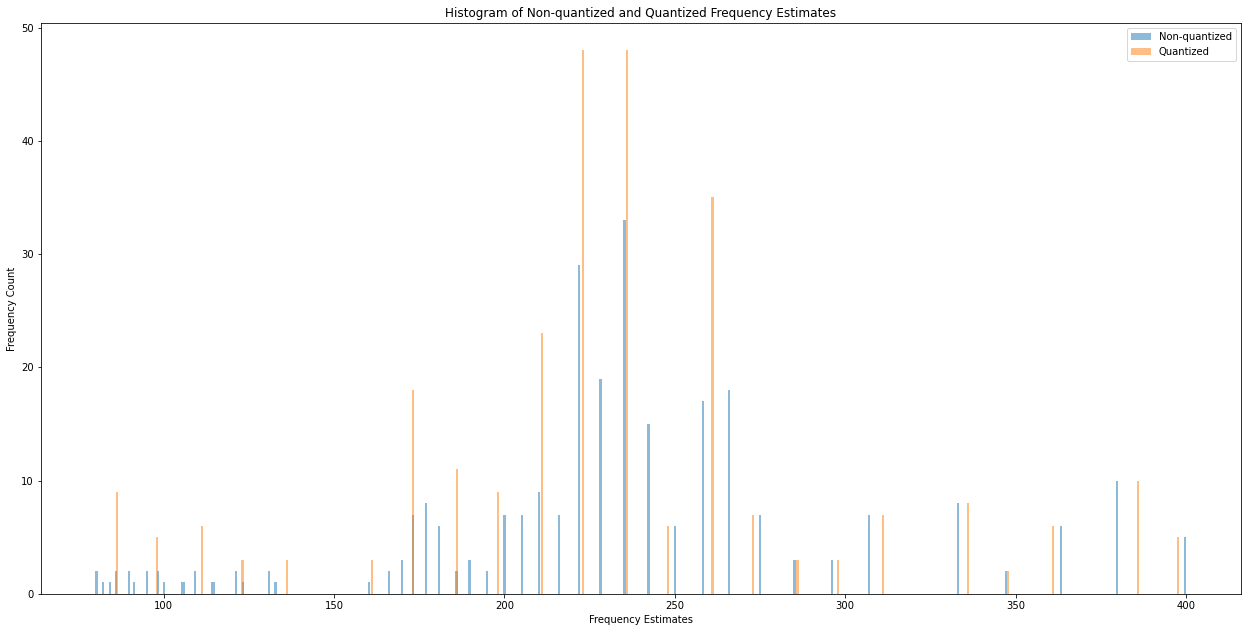

In [2692]:
# Set the number of bins for the histograms
num_bins = 500

# Plot the histograms
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
plt.hist(fundamental_freqs, bins=num_bins, alpha=0.5, label='Non-quantized')
plt.hist(freq_quantized_signal, bins=num_bins, alpha=0.5, label='Quantized')
plt.xlabel('Frequency Estimates')
plt.ylabel('Frequency Count')
plt.title('Histogram of Non-quantized and Quantized Frequency Estimates')
plt.legend()

# Show the plot
plt.show()

We would set x_range from 0 to 1, and the x_center to 0.5. We would need 1 bit.

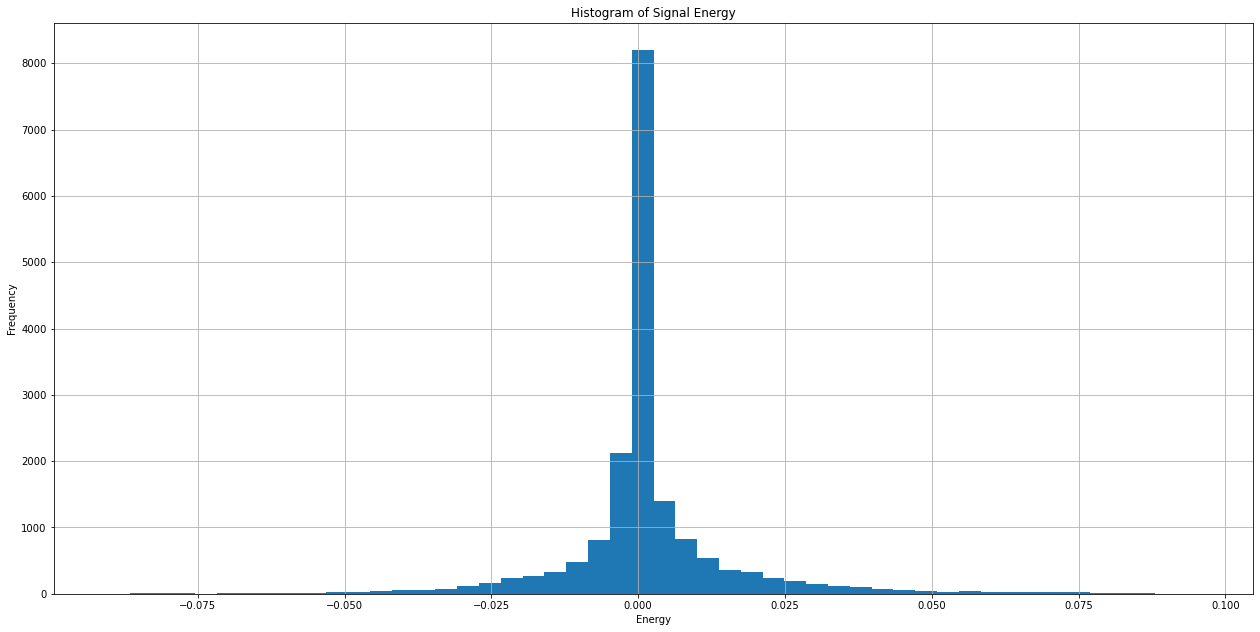

In [2693]:
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)

# Plot histogram
num_bins = 50
hist, bins, _ = plt.hist(variable_f0_signal_improved_quantized, bins=num_bins)

# Find appropriate values for x_range and x_center
x_range = (np.min(bins), np.max(bins))
x_center = (bins[:-1] + bins[1:]) / 2

# Display the plot
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of Signal Energy')
plt.grid(True)
plt.show()

In [2694]:
x_center = 0
x_range = 0.075*2

In [2695]:
quantized_idxs = quantize_encoder(variable_f0_signal_improved_quantized, 6, x_range, x_center)
quantized_idxs

the step is:  0.00234375


array([32., 32., 32., ..., 32., 32., 32.])

In [2696]:
quantized_signal = quantize_decoder(quantized_idxs, 6, x_range, x_center)
quantized_signal

array([0.00117188, 0.00117188, 0.00117188, ..., 0.00117188, 0.00117188,
       0.00117188])

In [2697]:
sd.play(variable_f0_signal_improved, sampling_rate)

In [2698]:
sd.play(quantized_signal, sampling_rate)

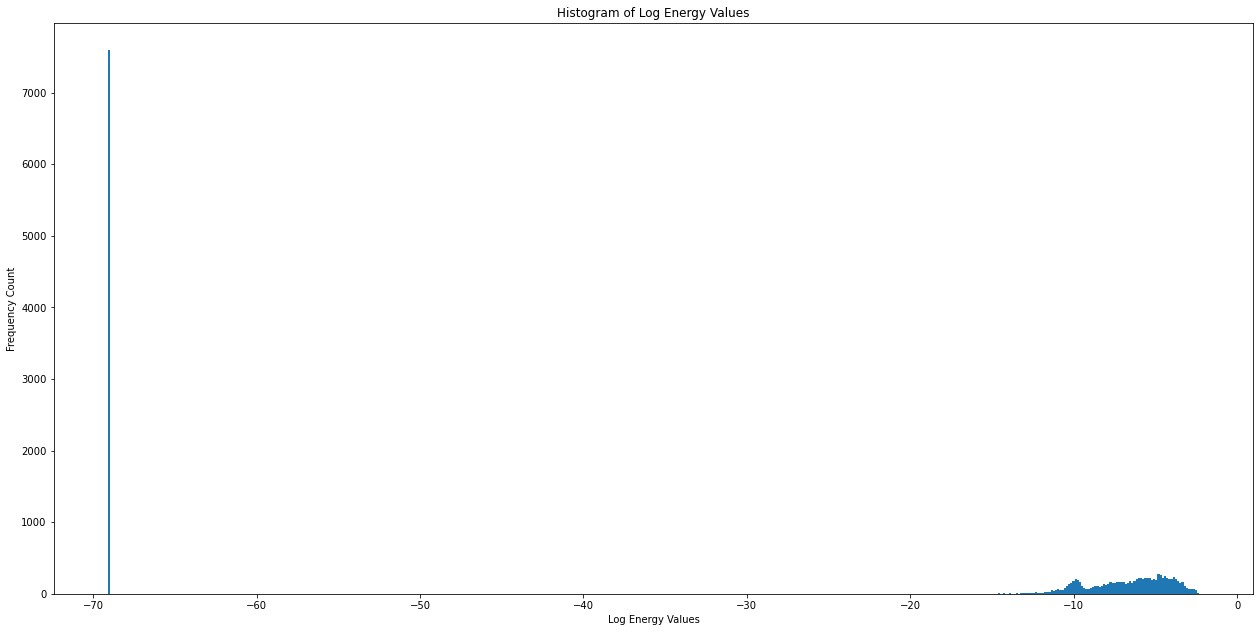

x_range: (-69.07755278982137, -2.348841610207027)
x_center: -33.29760339127763


In [2699]:
#4.3.c
# Take the logarithm of the energy values
fig = plt.gcf()
fig.set_size_inches(21.5, 10.5)
log_energy_values = np.log(np.maximum(variable_f0_signal_improved_quantized, 10**(-30)))

# Plot the histogram
num_bins = 500
plt.hist(log_energy_values, bins=num_bins)
plt.xlabel('Log Energy Values')
plt.ylabel('Frequency Count')
plt.title('Histogram of Log Energy Values')
plt.show()

# Find x_range and x_center
x_range = (np.min(log_energy_values), np.max(log_energy_values))
x_center = np.mean(log_energy_values)

print('x_range:', x_range)
print('x_center:', x_center)

In [2700]:
x_range = -2.208048425984188 - (-30.0)
x_center = (-2.208048425984188 + (-30.0))/2
print("x_center: ", x_center)
print("x_range: ", x_range)

x_center:  -16.104024212992094
x_range:  27.791951574015812


In [2701]:
quantized_idxs = quantize_encoder(log_energy_values, 8, x_range, x_center)

the step is:  -0.01725037832800147


4.3.d) The reason is that the logarithm compresses the signal to a smaller range, so we need less bits to represent it.

4.3.e) The better choice is the logarithmically quantized signal, because it is more robust to noise. As seen in the lecture companding schemes give a better SNR.

4.3.f) If the signal energy is too high, the logarithm will be too high and we will need more bits to represent it. furthermore, the logarithm range is [-infinity,infinity]. To avoid this we can use a companding scheme. (page 95)

In [2702]:
#4.4.a) The advantage of transmitting the relfection coefficients instead of the LPC coefficients is that the reflection coefficients are bounded between -1 and 1, while the LPCs can in theory be any value.

In [2703]:
#4.4.b) The advantage of quatizing LARs instead of reflection coefficients is that the LARs are bounded between 0 and 2, while the reflection coefficients are bounded between -1 and 1. And by applying the logarithm the values get compressed. Once disadvantage is that finding the LARs is more computationally expensive.

In [2704]:
#4.4.c)
m_lpc_new = np.zeros((m_lpc.shape[0], m_lpc.shape[1]+1), dtype=np.float64)
for i in range(m_lpc.shape[0]):
    m_lpc_new[i] = np.concatenate(([1], m_lpc[i]))
m_lpc_new

array([[ 1.        , -0.48480352, -0.08877985, ...,  0.07909403,
        -0.0591504 , -0.00951694],
       [ 1.        , -0.32393461, -0.10189708, ...,  0.02422038,
        -0.0636873 ,  0.04475632],
       [ 1.        , -0.24553832,  0.06628103, ..., -0.07158148,
        -0.14859201,  0.05263047],
       ...,
       [ 1.        , -0.33283113, -0.08350229, ...,  0.02969347,
        -0.10359454, -0.06138117],
       [ 1.        , -0.39762404, -0.13952387, ...,  0.16302971,
        -0.08526127, -0.11962726],
       [ 1.        , -0.33028678, -0.17122145, ...,  0.11640997,
        -0.04399617, -0.12424524]])

In [2705]:
from lpctools import poly2rc, rc2poly, rc2lar, lar2rc
reflection_coeffs = np.zeros((m_lpc.shape[0], m_lpc.shape[1]), dtype=np.float64)

for i in range(m_lpc_new.shape[0]):
    reflection_coeffs[i] = poly2rc(m_lpc_new[i])

reflection_coeffs

array([[-0.61354282, -0.18107399, -0.11903444, ...,  0.04749471,
        -0.06377002, -0.00951694],
       [-0.59109992, -0.29071732, -0.27270423, ...,  0.01301297,
        -0.04928791,  0.04475632],
       [-0.63852243, -0.26865691, -0.39042205, ..., -0.10973993,
        -0.13604605,  0.05263047],
       ...,
       [-0.56249403, -0.23534591, -0.25938016, ..., -0.01800464,
        -0.12449314, -0.06138117],
       [-0.51893711, -0.27089644, -0.23059026, ...,  0.09442339,
        -0.1347564 , -0.11962726],
       [-0.42430758, -0.22289651, -0.15561002, ...,  0.06768071,
        -0.08636595, -0.12424524]])

In [2706]:
LARs = rc2lar(reflection_coeffs)
LARs

array([[-1.42916647, -0.36618573, -0.23920295, ...,  0.09506094,
        -0.12771336, -0.01903445],
       [-1.35871002, -0.59869926, -0.55956599, ...,  0.0260274 ,
        -0.09865576,  0.08957247],
       [-1.51135016, -0.55083138, -0.82459579, ..., -0.22036733,
        -0.27378967,  0.1053583 ],
       ...,
       [-1.2729482 , -0.47968274, -0.53088748, ..., -0.03601318,
        -0.25028469, -0.12291686],
       [-1.14976808, -0.555662  , -0.46962557, ...,  0.18941104,
        -0.2711622 , -0.24040572],
       [-0.90586755, -0.45340399, -0.31376918, ...,  0.13556867,
        -0.17316331, -0.24978109]])

In [2707]:
#4.4.d)
x_center = (np.max(LARs) + np.min(LARs))/2
x_range = np.max(LARs) - np.min(LARs)
print("x_center: ", x_center)
print("x_range: ", x_range)
print("number of bits", 8)

x_center:  -0.5179144420616255
x_range:  8.371889338943301
number of bits 8


In [2714]:
quantized_idxs = quantize_encoder(LARs, 6, x_range, x_center)
quantized_idxs

the step is:  0.11462594460656328


array([[28., 37., 38., ..., 41., 39., 40.],
       [29., 35., 36., ..., 41., 40., 41.],
       [27., 36., 33., ..., 39., 38., 41.],
       ...,
       [29., 36., 36., ..., 40., 38., 39.],
       [31., 36., 36., ..., 42., 38., 38.],
       [33., 37., 38., ..., 42., 39., 38.]])

In [2715]:
quantized_signal = quantize_decoder(quantized_idxs, 6, x_range, x_center)
quantized_signal

array([[-1.43701969, -0.40538619, -0.29076024, ...,  0.05311759,
        -0.1761343 , -0.06150835],
       [-1.32239375, -0.63463808, -0.52001213, ...,  0.05311759,
        -0.06150835,  0.05311759],
       [-1.55164563, -0.52001213, -0.86388997, ..., -0.1761343 ,
        -0.29076024,  0.05311759],
       ...,
       [-1.32239375, -0.52001213, -0.52001213, ..., -0.06150835,
        -0.29076024, -0.1761343 ],
       [-1.09314186, -0.52001213, -0.52001213, ...,  0.16774353,
        -0.29076024, -0.29076024],
       [-0.86388997, -0.40538619, -0.29076024, ...,  0.16774353,
        -0.1761343 , -0.29076024]])

In [2716]:
reflection_coeffs_quantized = lar2rc(quantized_signal)
reflection_coeffs_quantized

array([[-0.61598542, -0.19996212, -0.14436449, ...,  0.02655255,
        -0.08784018, -0.03074449],
       [-0.57915938, -0.30708077, -0.25430121, ...,  0.02655255,
        -0.03074449,  0.02655255],
       [-0.65030257, -0.25430121, -0.40694548, ..., -0.08784018,
        -0.14436449,  0.02655255],
       ...,
       [-0.57915938, -0.25430121, -0.25430121, ..., -0.03074449,
        -0.14436449, -0.08784018],
       [-0.49794578, -0.25430121, -0.25430121, ...,  0.08367565,
        -0.14436449, -0.14436449],
       [-0.40694548, -0.19996212, -0.14436449, ...,  0.08367565,
        -0.08784018, -0.14436449]])

In [2717]:
m_lpc_quantized = np.zeros(m_lpc.shape, dtype=np.float64)
for i in range(m_lpc_quantized.shape[0]):
    m_lpc_quantized[i] = rc2poly(reflection_coeffs_quantized[i])[1:]
m_lpc_quantized

array([[-0.45853244, -0.09344346, -0.11340471, ...,  0.06967214,
        -0.0736598 , -0.03074449],
       [-0.31619576, -0.1416397 , -0.21633751, ...,  0.0324372 ,
        -0.03911861,  0.02655255],
       [-0.28290114,  0.10018521, -0.33557635, ..., -0.04302959,
        -0.15177445,  0.02655255],
       ...,
       [-0.31733557, -0.10086568, -0.19078547, ...,  0.02626367,
        -0.11537577, -0.08784018],
       [-0.38807797, -0.11997401, -0.32184937, ...,  0.15534727,
        -0.08533109, -0.14436449],
       [-0.33129119, -0.1502251 , -0.1837091 , ...,  0.13257163,
        -0.03818281, -0.14436449]])

In [2718]:
variable_f0_signal = np.zeros(voiced_ex_segments.shape)

counter = 0

for i in range(fundamental_freqs.shape[0]):
    f0 = sampling_rate // freq_quantized_signal[i]
    if voiced_unvoiced[i] == 1:
        for j in range(variable_f0_signal[i].shape[0]):
            counter = counter + 1
            if counter > f0:
                print(f'matched frequency {f0} at index [{i}][{j}]')
                variable_f0_signal[i][j] = 1
                counter = 0
            else:
                variable_f0_signal[i][j] = 0
    else:
        variable_f0_signal[i] = unvoiced_ex_segments[i]
variable_f0_signal[0][0] = 1

variable_f0_signal_filtered = lpc_filter_adaptively(variable_f0_signal, m_lpc_quantized)
variable_f0_signal_filtered

powers_variable_f0_signal_filtered = np.zeros(powers.shape, dtype=np.float64)
for i in range(powers.shape[0]):
    powers_variable_f0_signal_filtered[i] = compute_power(variable_f0_signal_filtered[i])


g = np.zeros(powers.shape)
for i in range(powers.shape[0]):
    g[i] = np.sqrt(powers[i] / np.maximum(powers_variable_f0_signal_filtered[i], 10**(-30)))

variable_f0_signal_filtered_scaled = apply_gain(variable_f0_signal_filtered, g)

variable_f0_signal_improved_quantized = reconstruct_signal(variable_f0_signal_filtered_scaled)

matched frequency 27 at index [0][27]
matched frequency 27 at index [0][55]
matched frequency 29 at index [1][21]
matched frequency 29 at index [1][51]
matched frequency 29 at index [2][17]
matched frequency 29 at index [2][47]
matched frequency 23 at index [3][7]
matched frequency 23 at index [3][31]
matched frequency 23 at index [3][55]
matched frequency 22 at index [4][14]
matched frequency 22 at index [4][37]
matched frequency 22 at index [4][60]
matched frequency 22 at index [5][19]
matched frequency 22 at index [5][42]
matched frequency 35 at index [6][14]
matched frequency 35 at index [6][50]
matched frequency 35 at index [7][22]
matched frequency 35 at index [7][58]
matched frequency 20 at index [8][15]
matched frequency 20 at index [8][36]
matched frequency 20 at index [8][57]
matched frequency 22 at index [9][16]
matched frequency 22 at index [9][39]
matched frequency 22 at index [9][62]
matched frequency 49 at index [10][48]
matched frequency 20 at index [11][5]
matched freq

In [2719]:
sd.play(variable_f0_signal_improved_quantized, sampling_rate)